In [1]:
from UTILITY_quickstart import *
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy as np
from UTILITY_setLattice import setLattice, getBendkG, getQuadkG, getSextkG, setBendkG, setQuadkG, setSextkG, setXOffset, setYOffset


importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.yml")

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],   
    csrTF = True,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_11505041459285934137.h5, and reinit to tao


In [2]:
setLattice(tao, **importedDefaultSettings)
trackBeam(tao, **importedDefaultSettings)

In [3]:
P = getBeamAtElement(tao, "ENDBC20")
makeBeamActiveBeamFile(P, tao = tao) 

## Golden FF optics

In [4]:
tao.cmd("set ele XTCAVF VOLTAGE = 0")
trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
POff = getBeamAtElement(tao, "DTOTR")
POff.write("/Users/nmajik/Golden_POff.h5")

tao.cmd("set ele XTCAVF VOLTAGE = 20e6")
trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
POn = getBeamAtElement(tao, "DTOTR")

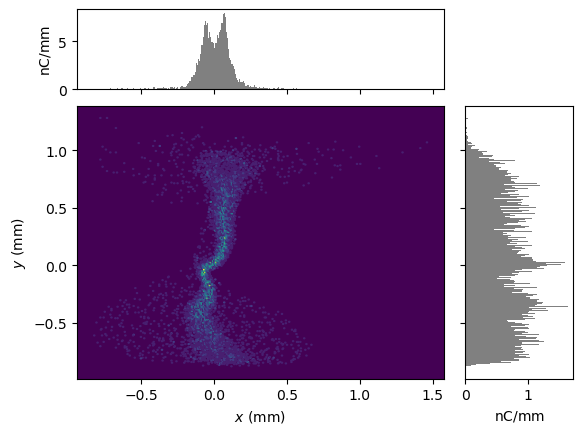

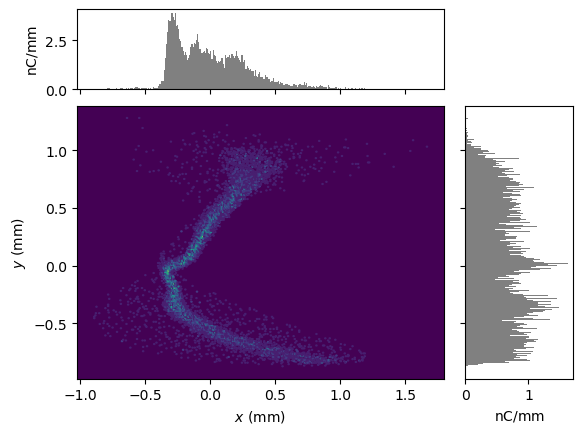

<Figure size 640x480 with 0 Axes>

In [5]:
display(plotMod(POff, 'x', 'y', bins=300))
display(plotMod(POn, 'x', 'y', bins=300))

plt.clf()

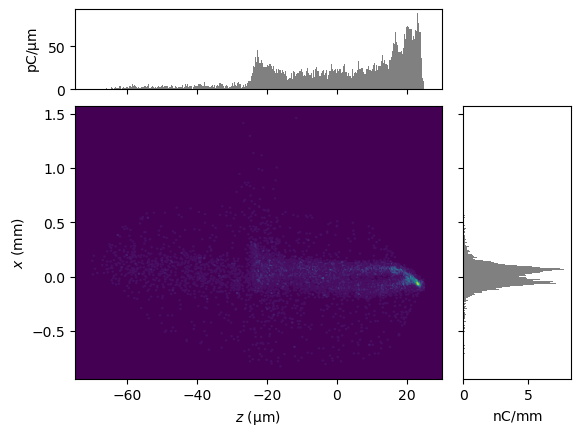

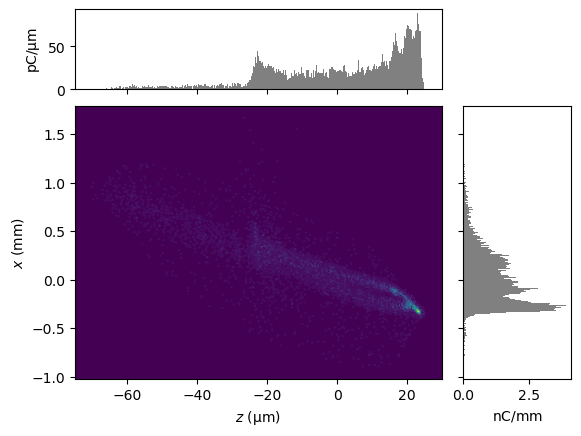

In [6]:
display(plotMod(POff, 'z', 'x', bins=300))
display(plotMod(POn, 'z', 'x', bins=300))

In [7]:
print(1e6 * smallestIntervalImpliedSigma(POff.x))
print(1e6 * smallestIntervalImpliedSigma(POn.x))
print(smallestIntervalImpliedSigma(POn.x) / smallestIntervalImpliedSigma(POff.x))

107.75112868181779
248.88313537366213
2.3097960867639555


## S20 configurator FF optics

In [8]:
#S20 configurator TCAV optics: https://docs.google.com/presentation/d/1pEDyfRYzVhJpeqzpDUfJOKxTxE6_achOUj4SHY-MoQQ/edit#slide=id.g2f39098462d_0_5

setQuadkG(tao, "Q5FF", -192)
setQuadkG(tao, "Q4FF", -162)
setQuadkG(tao, "Q3FF", 105)
setQuadkG(tao, "Q2FF", 120)
setQuadkG(tao, "Q1FF", -209)
setQuadkG(tao, "Q0FF", 120)
setQuadkG(tao, "Q0D", -139)
setQuadkG(tao, "Q1D", 225)
setQuadkG(tao, "Q2D", -139)

In [9]:
tao.cmd("set ele XTCAVF VOLTAGE = 0")
trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
POff = getBeamAtElement(tao, "DTOTR")
POff.write("/Users/nmajik/Configurator_POff.h5")

tao.cmd("set ele XTCAVF VOLTAGE = 20e6")
trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
POn = getBeamAtElement(tao, "DTOTR")

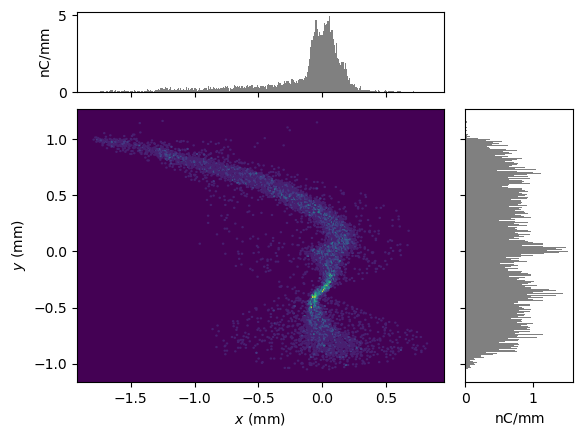

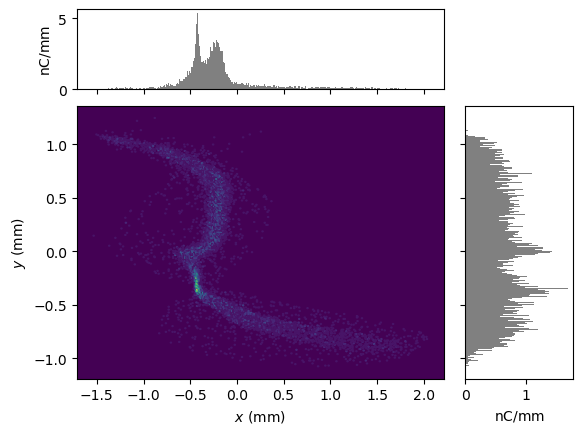

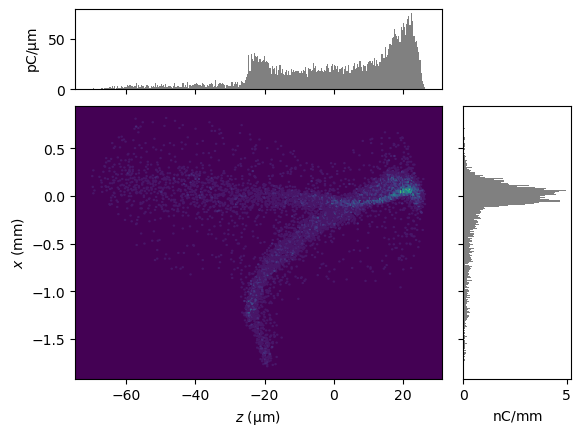

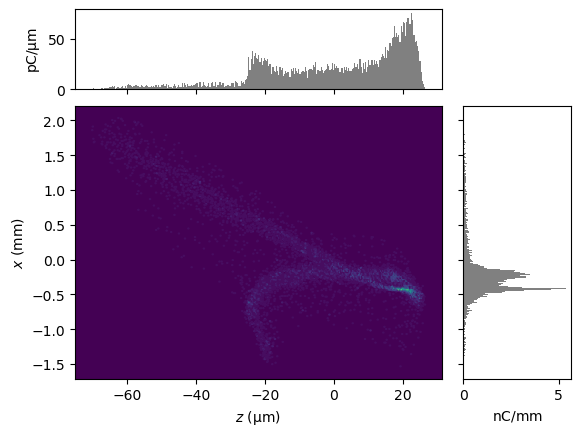

In [10]:
display(plotMod(POff, 'x', 'y', bins=300))
display(plotMod(POn, 'x', 'y', bins=300))
display(plotMod(POff, 'z', 'x', bins=300))
display(plotMod(POn, 'z', 'x', bins=300))

In [11]:
print(1e6 * smallestIntervalImpliedSigma(POff.x))
print(1e6 * smallestIntervalImpliedSigma(POn.x))
print(smallestIntervalImpliedSigma(POn.x) / smallestIntervalImpliedSigma(POff.x))

372.9051069372134
507.13968321595024
1.3599697987009283


## Optimize

In [ ]:
def objective(params, tao):
    Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG  = params
    
    try:
        #Prevent recalculation until changes are made
        tao.cmd("set global lattice_calc_on = F")
        
        setQuadkG(tao, "Q5FF", Q5FFkG)
        setQuadkG(tao, "Q4FF", Q4FFkG)
        setQuadkG(tao, "Q3FF", Q3FFkG)
        setQuadkG(tao, "Q2FF", Q2FFkG)
        setQuadkG(tao, "Q1FF", Q1FFkG)
        setQuadkG(tao, "Q0FF", Q0FFkG)
        setQuadkG(tao, "Q0D", Q0DkG)
        setQuadkG(tao, "Q1D", Q1DkG)
        setQuadkG(tao, "Q2D", Q2DkG)
        
        #Reenable lattice calculations
        tao.cmd("set global lattice_calc_on = T")

        tao.cmd("set ele XTCAVF VOLTAGE = 0")
        trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
        POff = getBeamAtElement(tao, "DTOTR")
        
        tao.cmd("set ele XTCAVF VOLTAGE = 20e6")
        trackBeam(tao, trackStart = "ENDBC20", trackEnd = "DTOTR", **importedDefaultSettings)
        POn = getBeamAtElement(tao, "DTOTR")
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20

    print( smallestIntervalImpliedSigma(POn.x) / smallestIntervalImpliedSigma(POff.x), Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG )
    
    return -1 * smallestIntervalImpliedSigma(POn.x) / smallestIntervalImpliedSigma(POff.x) 





quadNameList = ["Q5FF", "Q4FF", "Q3FF", "Q2FF", "Q1FF", "Q0FF", "Q0D", "Q1D", "Q2D"] 
initialGuess = [getQuadkG(tao, name) for name in quadNameList]

#For now, just hardcoding bounds... could generalize if required
#From "bounds.yml" as of 2025-01-10-11-11-35
# Q5FFkGBounds: (-256, 0)  #BCON = -70
# Q4FFkGBounds: (-446, 0)  #BCON = -71
# Q3FFkGBounds: (0, 457)   #BCON = 106
# Q2FFkGBounds: (0, 167)   #BCON = 112
# Q1FFkGBounds: (-257, 0)  #BCON = -225
# Q0FFkGBounds: (0, 167)   #BCON = 112
# Q0DkGBounds : (-239, 0)  #BCON = -112
# Q1DkGBounds : (0, 386)   #BCON = 177
# Q2DkGBounds : (-223, 0)  #BCON = -112

bounds = [(-256,0), (-446,0), (0,457), (0,167), (-257,0), (0,167), (-239,0), (0,386), (-223,0)]


# Perform optimization using Nelder-Mead
# result = minimize(
#     objective, 
#     initialGuess, 
#     method='Nelder-Mead',
#     bounds = bounds,
#     args = (tao)
# )

result = differential_evolution(
    objective, 
    bounds = bounds,
    args = (tao, ),
    #maxiter = 50,
    polish = False,
    disp = True
)

print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")


1.00494411009327 -229.69302498097406 -215.27992740583 401.39706638457307 14.932066920759524 -84.13816120260086 54.574333305975344 -230.87943911905205 201.75166574682427 -28.827341291455483
1.0074670368048657 -206.5365894864376 -245.0631318290183 129.66109345261995 118.47726483119625 -194.36038615805353 148.72805206216242 -236.16242882581417 46.38308453742013 -8.52739854128157
1.0345696345564053 -175.40499392944855 -208.472254111864 276.36351398855095 3.5480404035473043 -70.88310762014007 96.52001810329266 -43.6391648978791 4.409323968729723 -20.98948383655687
1.0787251246868579 -24.489936994054176 -17.02959895570538 143.54984390212348 63.15993987634431 -25.999613762053045 45.10236563398198 -131.21228175070723 122.481731414267 -13.937606491061672
1.0311323292208916 -10.496776971371418 -344.4349903160025 217.48216102853743 138.20876036882945 -221.29474932780204 140.21695276454014 -90.64366552196933 60.86605522283375 -213.23441891544644
0.9969917993248378 -162.24269082039785 -271.59764563